In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
deals = pd.read_csv("amocrm_deals.csv")
print(deals.shape)
deals.head()

(13870, 52)


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19T16:22:40+03:00,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20T09:46:10+03:00,14082937,0,6611476,0,NaN,143,1055,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26T17:01:28+03:00,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
3,18483639,2022-04-12T16:02:53+03:00,17892557,0,7603156,0,NaN,143,0,False,...,Москва,0.0,USD,0.0,Даниил,NaN,0.0,NaN,0.0,NaN
4,13076669,2022-06-15T15:19:53+03:00,18593211,0,7398229,0,NaN,35818369,0,False,...,Сергиев Посад,0.0,RUB,0.0,Анастасия Троякова,NaN,0.0,NaN,0.0,NaN


In [3]:
# обработка пропусков Status Time Proposal Sent

deals_with_sent_proposal = deals.loc[(deals['Status Time Proposal Sent'] != '1970-01-01T03:00:00+03:00') & (deals['Status Time Proposal Sent'].notna())]
print(deals_with_sent_proposal.shape)
deals_with_sent_proposal.head()

(9145, 52)


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19T16:22:40+03:00,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20T09:46:10+03:00,14082937,0,6611476,0,NaN,143,1055,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26T17:01:28+03:00,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
6,13076889,2022-04-15T12:31:14+03:00,17922813,0,7555906,0,NaN,35818141,0,False,...,Саранск,0.0,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN
7,23492037,2022-04-28T16:58:18+03:00,18044151,0,8021230,0,NaN,44209792,0,False,...,Новосибирск,0.0,RUB,0.0,Айнур,NaN,0.0,NaN,0.0,NaN


In [4]:
# исправление формата дат Created At и Status Time Proposal Sent

deals_with_sent_proposal['Created At'] = pd.to_datetime(deals_with_sent_proposal['Created At'], format="%Y-%m-%dT%H:%M:%S+03:00")
deals_with_sent_proposal['Status Time Proposal Sent'] = pd.to_datetime(deals_with_sent_proposal['Status Time Proposal Sent'], format="%Y-%m-%dT%H:%M:%S+03:00")
print(deals_with_sent_proposal.shape)
deals_with_sent_proposal.head()

(9145, 52)


<ipython-input-4-adb4bedb4e34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_with_sent_proposal['Created At'] = pd.to_datetime(deals_with_sent_proposal['Created At'], format="%Y-%m-%dT%H:%M:%S+03:00")
<ipython-input-4-adb4bedb4e34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_with_sent_proposal['Status Time Proposal Sent'] = pd.to_datetime(deals_with_sent_proposal['Status Time Proposal Sent'], format="%Y-%m-%dT%H:%M:%S+03:00")


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19 16:22:40,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20 09:46:10,14082937,0,6611476,0,NaN,143,1055,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26 17:01:28,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
6,13076889,2022-04-15 12:31:14,17922813,0,7555906,0,NaN,35818141,0,False,...,Саранск,0.0,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN
7,23492037,2022-04-28 16:58:18,18044151,0,8021230,0,NaN,44209792,0,False,...,Новосибирск,0.0,RUB,0.0,Айнур,NaN,0.0,NaN,0.0,NaN


In [5]:
# время подготовки КП

deals_with_sent_proposal['Proposal Send Time'] = deals_with_sent_proposal['Status Time Proposal Sent'] - deals_with_sent_proposal['Created At']
print(deals_with_sent_proposal.shape)
deals_with_sent_proposal.head()

(9145, 53)


<ipython-input-5-0230f40b9963>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_with_sent_proposal['Proposal Send Time'] = deals_with_sent_proposal['Status Time Proposal Sent'] - deals_with_sent_proposal['Created At']


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time
0,13972007,2021-08-19 16:22:40,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,13 days 18:03:53
1,13076667,2021-07-20 09:46:10,14082937,0,6611476,0,NaN,143,1055,False,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 00:21:28
2,20244751,2022-01-26 17:01:28,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN,26 days 00:43:18
6,13076889,2022-04-15 12:31:14,17922813,0,7555906,0,NaN,35818141,0,False,...,0.0,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN,45 days 06:41:33
7,23492037,2022-04-28 16:58:18,18044151,0,8021230,0,NaN,44209792,0,False,...,0.0,RUB,0.0,Айнур,NaN,0.0,NaN,0.0,NaN,32 days 08:22:32


In [6]:
# сколько в среднем готовится коммерческое предложение

print(deals_with_sent_proposal['Proposal Send Time'].mean(numeric_only=False))
print(deals_with_sent_proposal['Proposal Send Time'].median())
print(deals_with_sent_proposal['Proposal Send Time'].mode())
print(deals_with_sent_proposal['Proposal Send Time'].max())
print(deals_with_sent_proposal['Proposal Send Time'].min())

7 days 09:46:53.921377802
2 days 22:41:31
0   0 days 00:00:29
1   0 days 00:00:46
2   0 days 00:00:49
3   0 days 00:06:30
4   0 days 00:11:21
5   0 days 00:36:11
6   2 days 01:28:12
dtype: timedelta64[ns]
638 days 07:42:41
0 days 00:00:03


In [7]:
deals_with_sent_proposal['Round Proposal Send Time'] = deals_with_sent_proposal['Proposal Send Time'].round('d')
deals_with_sent_proposal['Group Proposal Send Time'] = deals_with_sent_proposal['Round Proposal Send Time'].astype(str).str.replace(" days", "")
deals_with_sent_proposal['Group Proposal Send Time'] = pd.to_numeric(deals_with_sent_proposal['Group Proposal Send Time'])

print(deals_with_sent_proposal.shape)
deals_with_sent_proposal.head()

(9145, 55)


<ipython-input-7-47f033cbcb55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_with_sent_proposal['Round Proposal Send Time'] = deals_with_sent_proposal['Proposal Send Time'].round('d')
<ipython-input-7-47f033cbcb55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_with_sent_proposal['Group Proposal Send Time'] = deals_with_sent_proposal['Round Proposal Send Time'].astype(str).str.replace(" days", "")
<ipython-input-7-47f033cbcb55>:3: SettingWithCopyWarning: 
A value is trying to be set on a co

,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time,Round Proposal Send Time,Group Proposal Send Time
0,13972007,2021-08-19 16:22:40,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,13 days 18:03:53,14 days,14
1,13076667,2021-07-20 09:46:10,14082937,0,6611476,0,NaN,143,1055,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 00:21:28,0 days,0
2,20244751,2022-01-26 17:01:28,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,0.0,Даниил,NaN,0.0,workdays,30.0,NaN,26 days 00:43:18,26 days,26
6,13076889,2022-04-15 12:31:14,17922813,0,7555906,0,NaN,35818141,0,False,...,0.0,Рустам,NaN,0.0,NaN,0.0,NaN,45 days 06:41:33,45 days,45
7,23492037,2022-04-28 16:58:18,18044151,0,8021230,0,NaN,44209792,0,False,...,0.0,Айнур,NaN,0.0,NaN,0.0,NaN,32 days 08:22:32,32 days,32


In [8]:
# как много КП готовится за 0 (в течение дня), 1, 2, 3 дня?

for i in range(4):
    print("{}:".format(i), 
          len(deals_with_sent_proposal[deals_with_sent_proposal['Round Proposal Send Time'] == '{} days'.format(i)]), 
          "({:.2f}%)".format(round(len(deals_with_sent_proposal[deals_with_sent_proposal['Round Proposal Send Time'] == '{} days'.format(i)])/deals_with_sent_proposal.shape[0], 4)*100))

0: 1958 (21.41%)
1: 1599 (17.48%)
2: 762 (8.33%)
3: 724 (7.92%)


In [9]:
# сделки с тэгами "Репутационная сделка" или "Срочный запрос"

deals_with_high_priority = deals_with_sent_proposal.loc[deals_with_sent_proposal['Tags'].str.contains("Репутационная сделка|Срочный запрос", na=False)]
print(deals_with_high_priority.shape)
deals_with_high_priority.head()

(1111, 55)


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time,Round Proposal Send Time,Group Proposal Send Time
1,13076667,2021-07-20 09:46:10,14082937,0,6611476,0,NaN,143,1055,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 00:21:28,0 days,0
7,23492037,2022-04-28 16:58:18,18044151,0,8021230,0,NaN,44209792,0,False,...,0.0,Айнур,NaN,0.0,NaN,0.0,NaN,32 days 08:22:32,32 days,32
15,20974773,2022-03-16 19:12:52,17582917,0,7603156,0,NaN,38424292,494,False,...,0.0,Даниил,NaN,0.0,NaN,0.0,NaN,0 days 04:25:01,0 days,0
72,13349953,2021-10-05 16:24:29,15267023,0,6473404,519145,Предоплата,142,1610,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 17:37:28,1 days,1
76,15753735,2021-12-28 11:00:21,16540551,0,7398229,519143,Постоплата,142,2200,False,...,48200.0,Другой,NaN,0.0,NaN,0.0,NaN,0 days 23:48:37,1 days,1


In [10]:
print(deals_with_high_priority['Proposal Send Time'].mean(numeric_only=False))
print(deals_with_high_priority['Proposal Send Time'].median())
print(deals_with_high_priority['Proposal Send Time'].mode())
print(deals_with_high_priority['Proposal Send Time'].max())
print(deals_with_high_priority['Proposal Send Time'].min())

7 days 14:18:51.252025202
2 days 04:49:29
0   0 days 02:14:11
1   1 days 01:28:10
dtype: timedelta64[ns]
264 days 03:40:29
0 days 00:00:49


In [11]:
# сделки без тэгов "Репутационная сделка" или "Срочный запрос"

deals_with_lower_priority = deals_with_sent_proposal.loc[~deals_with_sent_proposal['Tags'].str.contains("Репутационная сделка|Срочный запрос", na=False)]
print(deals_with_lower_priority.shape)
deals_with_lower_priority.head()

(8034, 55)


,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time,Round Proposal Send Time,Group Proposal Send Time
0,13972007,2021-08-19 16:22:40,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,13 days 18:03:53,14 days,14
2,20244751,2022-01-26 17:01:28,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,0.0,Даниил,NaN,0.0,workdays,30.0,NaN,26 days 00:43:18,26 days,26
6,13076889,2022-04-15 12:31:14,17922813,0,7555906,0,NaN,35818141,0,False,...,0.0,Рустам,NaN,0.0,NaN,0.0,NaN,45 days 06:41:33,45 days,45
8,13085271,2021-04-13 18:07:58,12558323,0,6473404,519145,Предоплата,142,497,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 21:51:18,1 days,1
9,17478717,2021-07-20 10:07:53,14083211,0,6611476,0,NaN,143,0,False,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 10:51:50,0 days,0


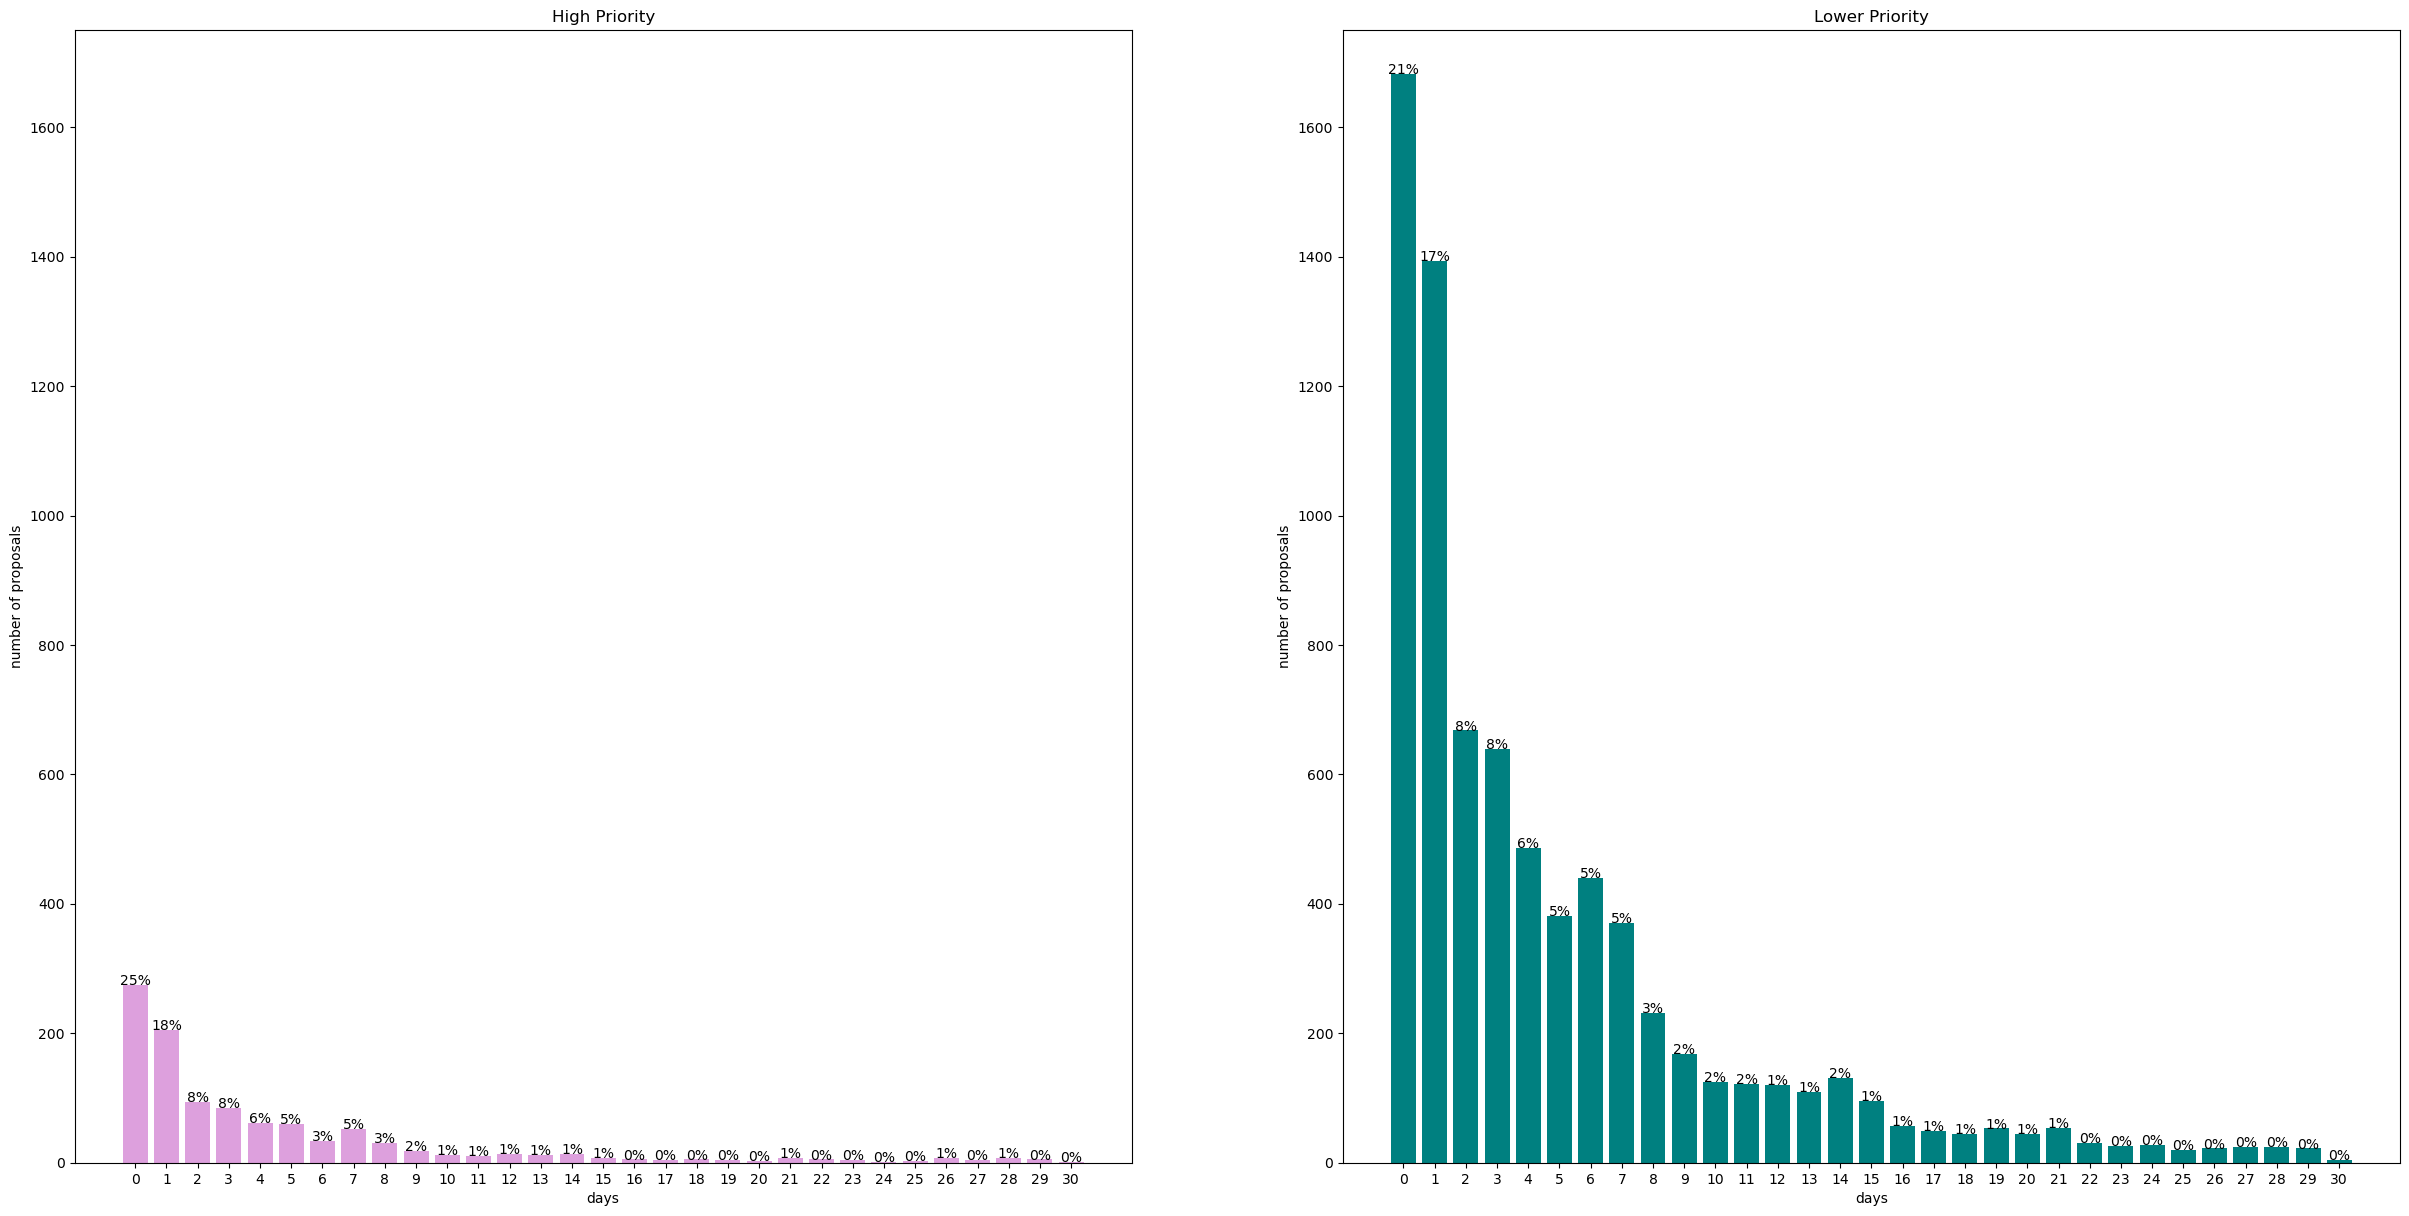

In [12]:
lower_priority_list = []
lower_priority_percentage = []
high_priority_list = []
high_priority_percentage = []
for i in range(31):
    high_priority_list.append(len(deals_with_high_priority[deals_with_high_priority['Group Proposal Send Time'] == i]))
    lower_priority_list.append(len(deals_with_lower_priority[deals_with_lower_priority['Group Proposal Send Time'] == i]))
                              
    high_priority_percentage.append(round(len(deals_with_high_priority[deals_with_high_priority['Group Proposal Send Time'] == i]) 
                                          / deals_with_high_priority.shape[0], 4) * 100)
    lower_priority_percentage.append(round(len(deals_with_lower_priority[deals_with_lower_priority['Group Proposal Send Time'] == i]) 
                                           / deals_with_lower_priority.shape[0], 4) * 100)
d = np.arange(0, 31)

fig, axs = plt.subplots(1, 2, figsize=(30,15), dpi=100)

axs[0].set_ylim(top=1750)
axs[0].set_title('High Priority')
axs[0].set_xlabel('days')
axs[0].set_ylabel('number of proposals')
axs[0].set_xticks(d)
axs[0].bar(d, high_priority_list, color='plum')

patches1 = axs[0].patches
for i in range(len(patches1)):
    x = patches1[i].get_x() + patches1[i].get_width() / 2
    y = patches1[i].get_height() + .05
    axs[0].annotate('{:.0f}%'.format(high_priority_percentage[i]), (x, y), ha='center')

axs[1].set_ylim(top=1750)
axs[1].set_title('Lower Priority')
axs[1].set_xlabel('days')
axs[1].set_ylabel('number of proposals')
axs[1].set_xticks(d)
axs[1].bar(d, lower_priority_list, color='teal')

patches2 = axs[1].patches
for i in range(len(patches2)):
    x = patches2[i].get_x() + patches2[i].get_width() / 2
    y = patches2[i].get_height() + .05
    axs[1].annotate('{:.0f}%'.format(lower_priority_percentage[i]), (x, y), ha='center')
    
# количество КП, подготовленных за 0-30 дней для сделок с высоким приоритетом и всех остальных
# над столбцами подписан процент КП, подготовленных за указанное количество дней, к общему числу сделок данного приоритета

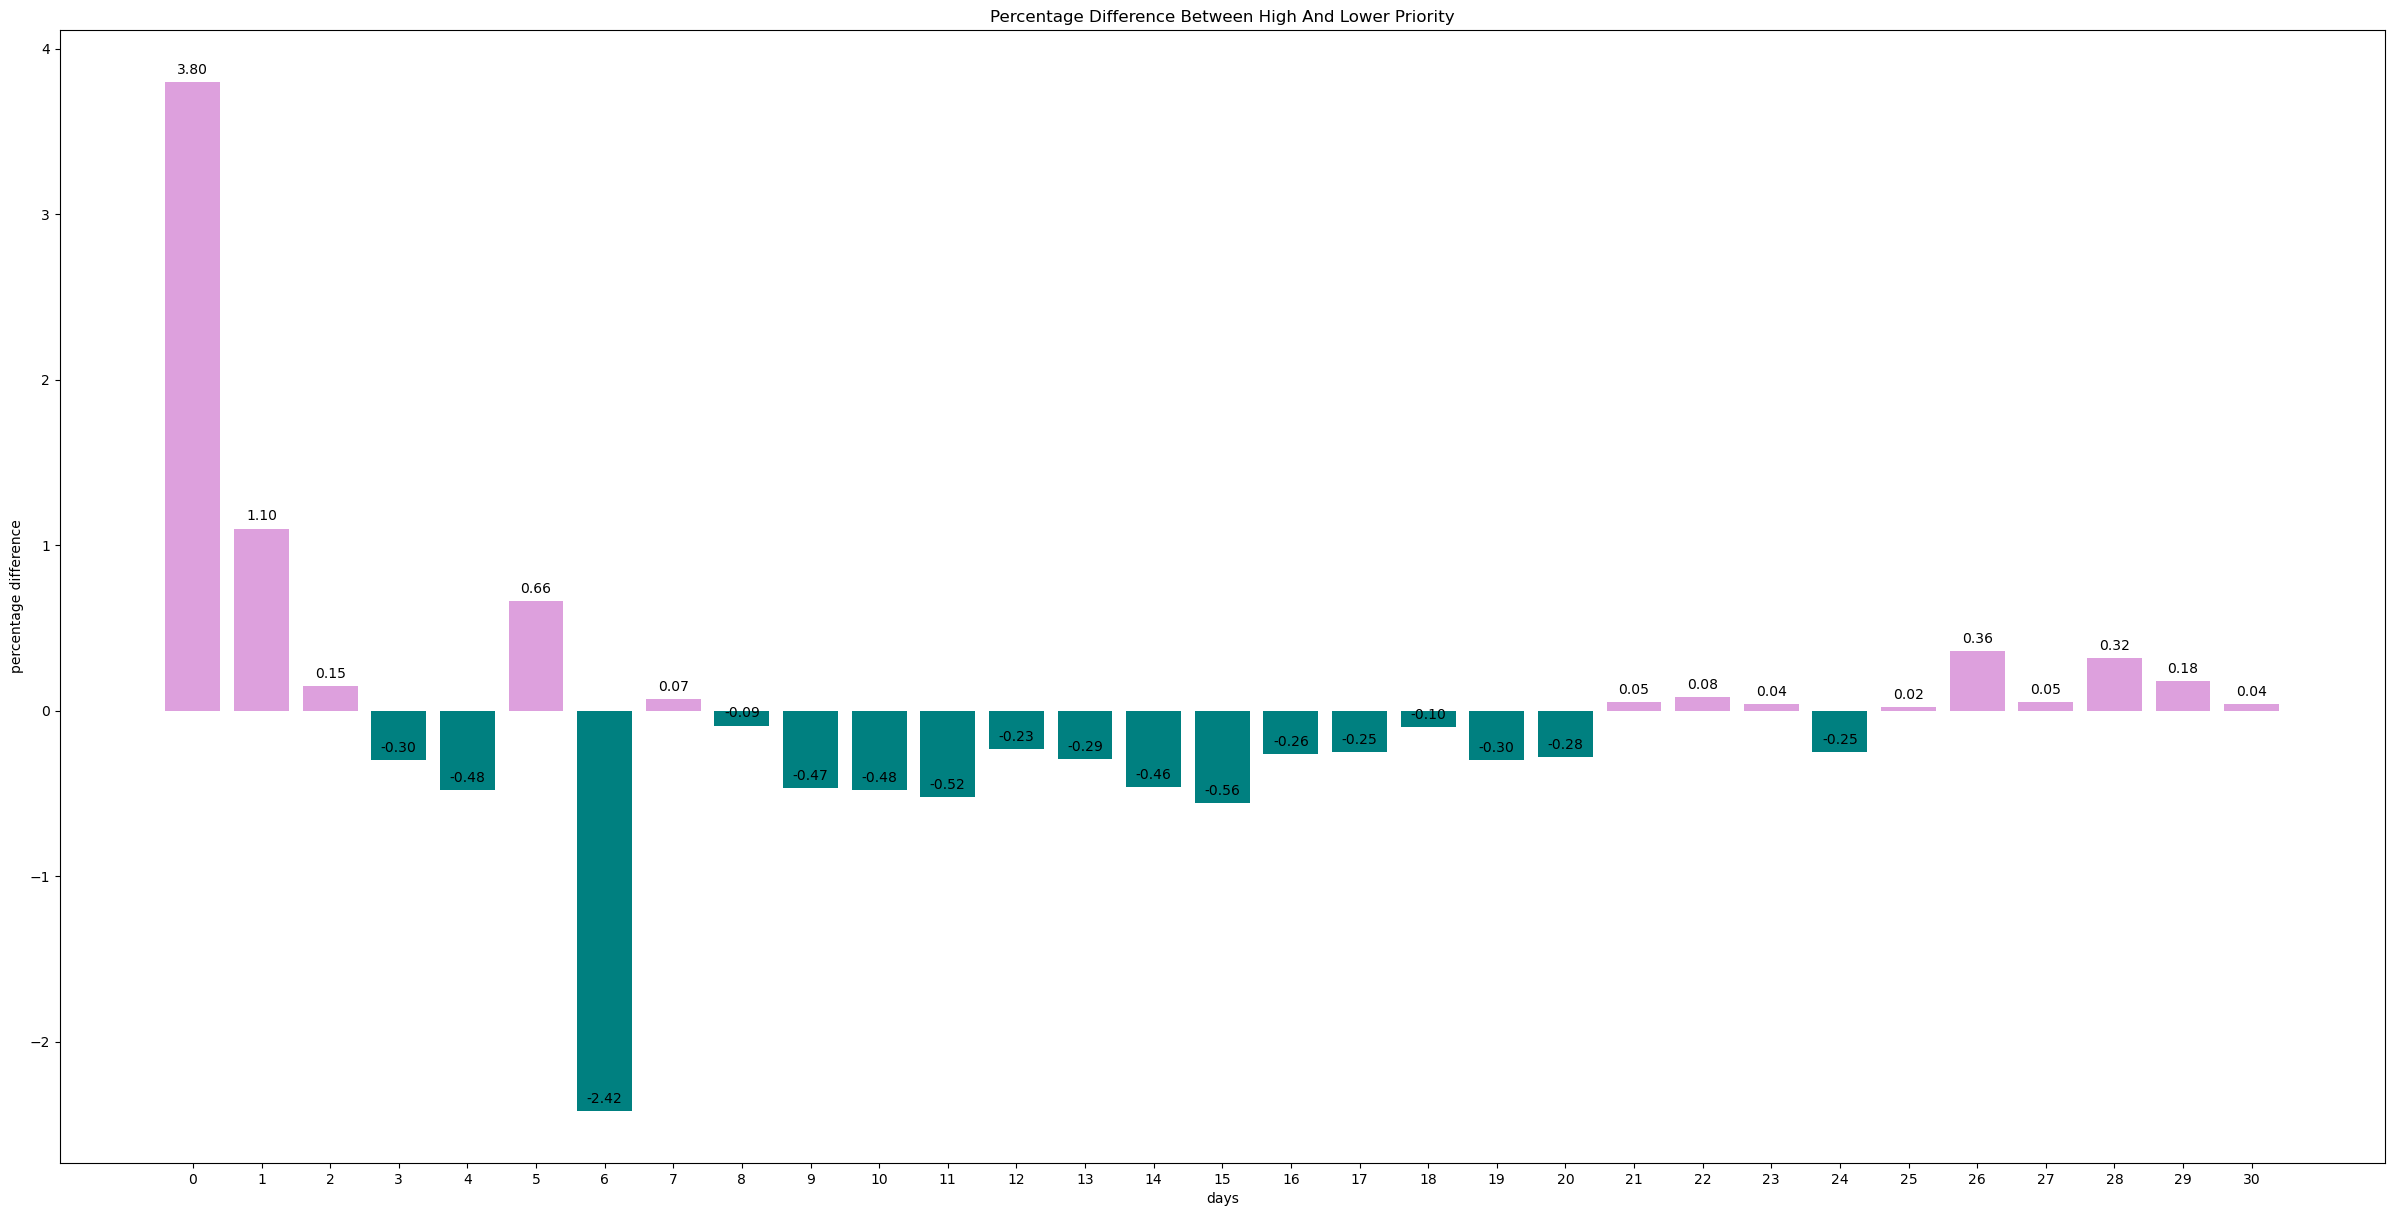

In [13]:
percentage_difference = [k - j for k, j in zip(high_priority_percentage, lower_priority_percentage)]

color = []
for i in range(31):
    if (percentage_difference[i] > 0):
        color.append('plum')
    else: color.append('teal')

fig, axs = plt.subplots(1, 1, figsize=(30,15), dpi=100)
axs.set_title('Percentage Difference Between High And Lower Priority')
axs.set_xlabel('days')
axs.set_ylabel('percentage difference')
axs.set_xticks(d)
axs.bar(d, percentage_difference, color=color)

patches = axs.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + .05
    axs.annotate('{:.2f}'.format(percentage_difference[i]), (x, y), ha='center')
    
# помогают ли тэги "Репутационная сделка", "Срочный запрос" выставить КП быстрее? 
# -- судя по всему, нет: тэги помогли лишь незначительно увеличить процентное отношение КП, подготовленных в течение дня (3.8%)

In [14]:
from scipy.stats import mode

agg_func_math = {
    'Group Proposal Send Time': ['count', 'mean', 'median', mode, 'min', 'max']
}
company_analysis = deals_with_sent_proposal.groupby(by=['Company ID'], as_index=False).agg(agg_func_math).round(2)
print(company_analysis.shape)
company_analysis.head()

(583, 7)


Company ID Group Proposal Send Time                                 
                                count  mean median        mode min max
0          0                       20  7.20    2.5  ([0], [5])   0  89
1    6717273                       52  4.54    2.5  ([1], [9])   0  35
2    6953233                        1  0.00    0.0  ([0], [1])   0   0
3    6954079                       29  6.48    3.0  ([2], [6])   0  48
4    7343939                        6  5.33    5.0  ([0], [2])   0  14

In [15]:
print(company_analysis.columns)
company_analysis = company_analysis.loc[(company_analysis['Company ID', ''] != 0) 
                                        & (company_analysis['Group Proposal Send Time', 'count'] > 1)]
print(company_analysis)

MultiIndex([(              'Company ID',       ''),
            ('Group Proposal Send Time',  'count'),
            ('Group Proposal Send Time',   'mean'),
            ('Group Proposal Send Time', 'median'),
            ('Group Proposal Send Time',   'mode'),
            ('Group Proposal Send Time',    'min'),
            ('Group Proposal Send Time',    'max')],
           )
    Company ID Group Proposal Send Time                                   
                                  count   mean median        mode min  max
1      6717273                       52   4.54    2.5  ([1], [9])   0   35
3      6954079                       29   6.48    3.0  ([2], [6])   0   48
4      7343939                        6   5.33    5.0  ([0], [2])   0   14
5      7696247                        2   3.00    3.0  ([1], [1])   1    5
7      9173341                        2   2.00    2.0  ([0], [1])   0    4
..         ...                      ...    ...    ...         ...  ..  ...
561   24239665        